In [ ]:
#Une fois le dataframe complet optimisé, on peut mener l'analyse en stats descriptives

In [105]:
#Lib
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import calendar

In [92]:
#LISTE DES STATS DES POSSIBLES

#Observations générales
'''
- boxplots
- describe/summary (uniquement pour les colonnes : scores, note moyenne, nb votes, durée)
'''

#Calculs d'effectifs/répartition/proportions
'''
- Evolution dans le temps des effectifs de film produits
- groupby month => effectifs de films produits en fonction de la période de l'année
- recoder les var quanti en déciles
'''

#Plots 
'''
- est-ce que les films moins connus sont mieux notés ? (corrélation négative entre Note_moyenne et Nb_votes ?)
- Note_moyenne en fonction de la durée
- Note_moyenne en fonction des genres (histogramme)
- Note_moyenne en fonction du mois
- Note_moyenne en fonction des scores (actors and directors)
'''

'\n- est-ce que les films moins connus sont mieux notés ? (corrélation négative entre Note_moyenne et Nb_votes ?)\n- Note_moyenne en fonction de la durée\n- Note_moyenne en fonction des genres (histogramme)\n- Note_moyenne en fonction du mois\n- Note_moyenne en fonction des scores (actors and directors)\n'

In [106]:
#récupérer la base de données complète
movies_rating = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz")
movies_rating_clean = movies_rating["tconst\taverageRating\tnumVotes"].str.split("\\t", expand=True)
movies_rating_clean.columns = ['ID', 'Note_moyenne', 'Nombre_de_votes']
movies_rating_clean['Note_moyenne'] = movies_rating_clean['Note_moyenne'].astype(float)
movies_rating_clean['Nombre_de_votes'] = movies_rating_clean['Nombre_de_votes'].astype(float)
movies_rating_filtré = movies_rating_clean[movies_rating_clean.Nombre_de_votes > 1999]

df = pd.read_csv('https://raw.githubusercontent.com/Jeremstar/Succes_de_films-IMDb/main/Database/IMDB_2000votes.csv', 
                 converters={"actor": lambda x: x.strip("[]").split(", "), 'director': lambda y : y.strip("[]").split(", "),"genre": lambda x: x.strip("[]").split(", ")}) 

movies_rating_filtré['url']='/title/'+movies_rating_filtré['ID']+'/'
df_fusionné = df.merge(movies_rating_filtré, on='url',how='left')

df_fusionné = df_fusionné.reindex(columns=['ID_y','name','alternateName','url','contentRating','datePublished','genre','actor','director','creator','Origine','Budget','duration','keywords','Note_moyenne','Nombre_de_votes','ID_x'])	
df_fusionné =df_fusionné.drop(['ID_x', 'Budget', 'alternateName', 'creator'],axis=1) #On drop creator, pour les questions de scrap évoquées plus tôt, et budget parce qu'il est 
df_fusionné.rename(columns={'ID_y':'ID'}, inplace= True)




#recodage mois + création colonne mois en français
index_with_nan = df.index[df_fusionné.loc[:,'datePublished'].isnull()]
df_fusionné.drop(index_with_nan,0, inplace=True)

df_fusionné['month'] = pd.DatetimeIndex(df_fusionné['datePublished']).month
df_fusionné['month'] = df_fusionné['month'].astype(int)
df_fusionné['month_name'] = df_fusionné['month'].apply(lambda x: calendar.month_abbr[x])



#corrections
def correcteur(colonne, old, new) :
    if type(df_fusionné[colonne][0]) == list :
        all_crews = []
        for crew in df_fusionné[colonne]:
            crew_corrigé = []
            if crew != [] :
                for individu in crew :
                    crew_corrigé.append(individu.replace(old, new))
            all_crews.append(crew_corrigé)
        df_fusionné[colonne] = all_crews
    else :
        df_fusionné[colonne]= df_fusionné[colonne].str.replace(old, new, case = False)
        
correcteur('actor', '&apos;', "'")
correcteur('director', '&apos;', "'")
correcteur('name', '&apos;', "'")

from pandas.core.common import flatten

print(type(df_fusionné['genre']))
def valeurs_possibles (colonne) :
    list_nonflat = df_fusionné[colonne]
    flat_list = list(flatten(list_nonflat))
    liste_valeurs = list(set(flat_list))
    return liste_valeurs

/tmp/ipykernel_99/1163823738.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_rating_filtré['url']='/title/'+movies_rating_filtré['ID']+'/'
/tmp/ipykernel_99/1163823738.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_fusionné.drop(index_with_nan,0, inplace=True)


<class 'pandas.core.series.Series'>


In [81]:
df_fusionné.head(10)

,ID,name,url,contentRating,datePublished,genre,actor,director,Origine,duration,keywords,Note_moyenne,Nombre_de_votes,month,month_name
0,tt0000005,Blacksmith Scene,/title/tt0000005/,Unrated,1893-05-09,"['Short', 'Comedy']","['Charles Kayser', 'John Ott']",['William K.L. Dickson'],United States,PT1M,"blacksmith,national film registry,beer,two wor...",6.2,2555.0,5,May
1,tt0000008,Edison Kinetoscopic Record of a Sneeze,/title/tt0000008/,NaN,1894-01-09,"['Documentary', 'Short']",['Fred Ott'],['William K.L. Dickson'],United States,PT1M,"national film registry,year 1894,1890s,19th ce...",5.4,2070.0,1,Jan
2,tt0000010,La sortie de l'usine Lumière à Lyon,/title/tt0000010/,Not Rated,1895-03-22,"['Documentary', 'Short']",[],['Louis Lumière'],France,PT1M,"reference to lumiere brothers,reference to the...",6.9,6997.0,3,Mar
3,tt0000012,L'arrivée d'un train à La Ciotat,/title/tt0000012/,Not Rated,1896-01-25,"['Documentary', 'Short']","['Madeleine Koehler', 'Marcel Koehler', 'Mrs. ...","['Auguste Lumière', 'Louis Lumière']",France,PT1M,"actuality film,year 1896,train,train station,1...",7.4,12003.0,1,Jan
6,tt0000070,Démolition d'un mur,/title/tt0000070/,Not Rated,1896-03-06,"['Documentary', 'Short']",['Auguste Lumière'],['Louis Lumière'],France,PT1M,"year 1896,demolition,1890s,19th century",6.4,2596.0,3,Mar
7,tt0000091,Le manoir du diable,/title/tt0000091/,Not Rated,1896-12-24,"['Short', 'Horror']","['Jehanne d'Alcy', 'Jules-Eugène Legris', 'Geo...",['Georges Méliès'],France,PT3M,"vampire,monster,supernatural power,psychotroni...",6.7,3560.0,12,Dec
10,tt0000417,Le voyage dans la lune,/title/tt0000417/,Tous publics,1902-09-01,"['Short', 'Action', 'Adventure']","['Georges Méliès', 'Victor André', 'Bleuette B...",['Georges Méliès'],France,PT13M,"moon,astronomer,alien,satire,jules verne",8.2,50569.0,9,Sep
12,tt0000439,The Great Train Robbery,/title/tt0000439/,TV-G,1904-05-08,"['Short', 'Action', 'Adventure']","['Gilbert M. 'Broncho Billy' Anderson', 'A.C. ...",['Edwin S. Porter'],France,PT11M,"national film registry,posse,horse,dance,passe...",7.3,19534.0,5,May
14,tt0000499,Le voyage à travers l'impossible,/title/tt0000499/,Not Rated,1904-07-31,"['Short', 'Action', 'Adventure']","['Georges Méliès', 'Fernande Albany', 'Jehanne...",['Georges Méliès'],France,PT24M,"voyage,trip,institute,alps,snow",7.5,3639.0,7,Jul
15,tt0000682,Fantasmagorie,/title/tt0000682/,NaN,1908-08-17,"['Animation', 'Short', 'Comedy']",[],['Émile Cohl'],France,PT2M,"blown up like a balloon,male police officer,st...",6.9,2555.0,8,Aug


In [126]:
# OBSERVATIONS GENERALES DES VAR QUANTI

<AxesSubplot: >

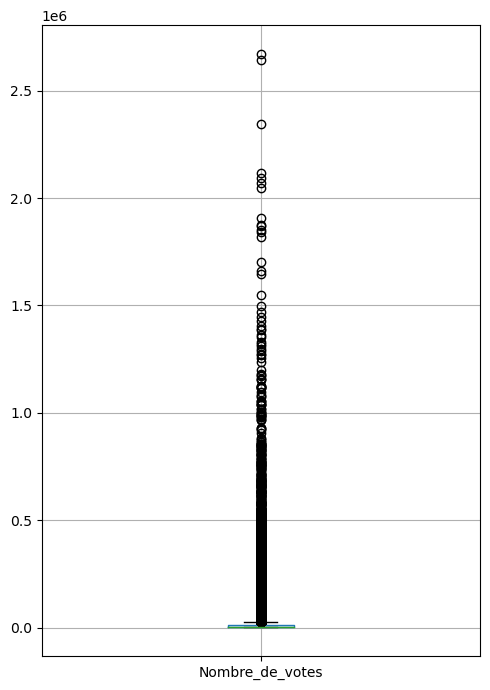

In [100]:
#boxplots (attention il faut pas les lancer les 2 en mm temps)
df_fusionné.boxplot(column=['Nombre_de_votes'], figsize=(5,7)) #bof, voir si on peut faire qqch pour voir changer l'échelle

<AxesSubplot: >

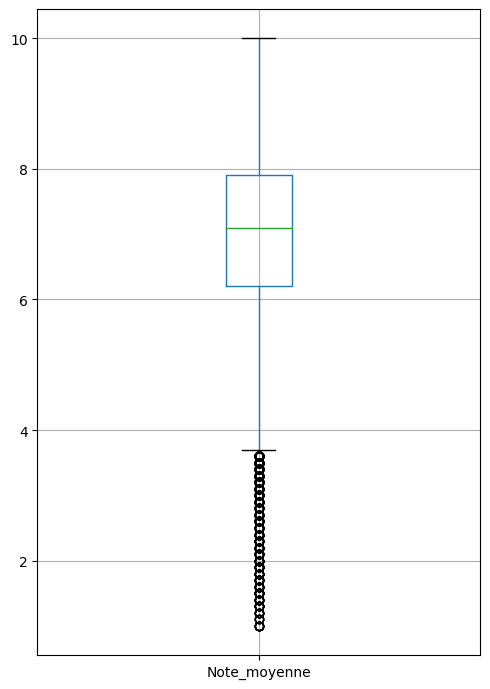

In [101]:
df_fusionné.boxplot(column=['Note_moyenne'], figsize=(5,7))

In [97]:
#tableau stats générales : scores, note moyenne, nb votes, durée (à rajouter)
df_fusionné[['Note_moyenne','Nombre_de_votes']].describe()

,Note_moyenne,Nombre_de_votes
count,46783.000000,4.678300e+04
mean,6.979213,2.495014e+04
std,1.308252,8.626901e+04
min,1.000000,2.000000e+03
25%,6.200000,2.896000e+03
50%,7.100000,4.678000e+03
75%,7.900000,1.235450e+04
max,10.000000,2.670872e+06


In [ ]:
# EFFECTIFS / DISTRIBUTION DES PROPORTIONS

<BarContainer object of 12 artists>

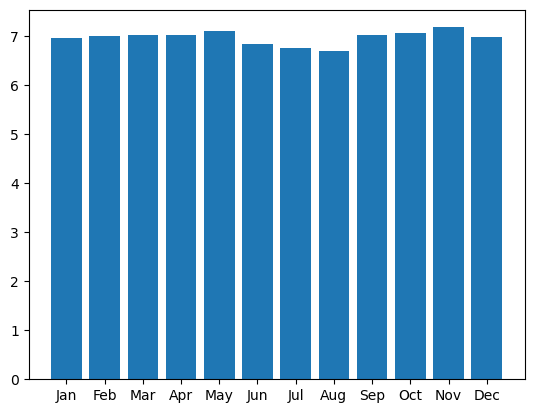

In [87]:
# Nb films sortis par mois
films_par_mois = df_fusionné.groupby('month_name')['ID'].count().rename_axis('month_name').reset_index(name='nb_films')
films_par_mois = films_par_mois.reindex([4,3,7,0,8,6,5,1,11,10,9,2])

notes_par_mois = df_fusionné.groupby('month_name')['Note_moyenne'].mean().rename_axis('month_name').reset_index(name='note_moyenne')
notes_par_mois = notes_par_mois.reindex([4,3,7,0,8,6,5,1,11,10,9,2])

plt.bar(films_par_mois['month_name'],films_par_mois['nb_films'])
plt.bar(notes_par_mois['month_name'],notes_par_mois['note_moyenne'])

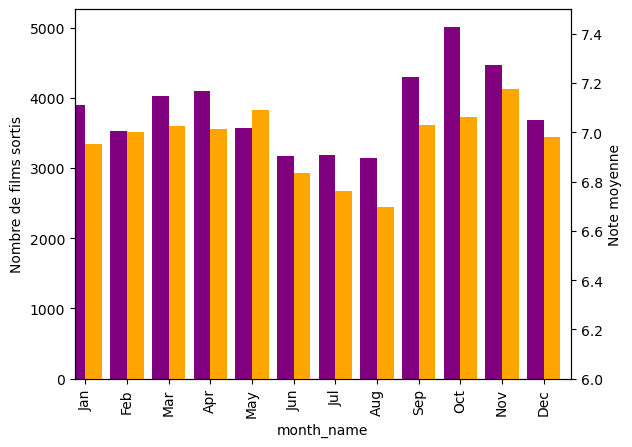

In [103]:
#les deux sur le même
#jointure des 2 tableaux d'abord
nb_notes_par_mois = films_par_mois.merge(notes_par_mois, on='month_name',how='left')
nb_notes_par_mois = nb_notes_par_mois.set_index('month_name')
nb_notes_par_mois

#puis le graphe
graph = plt.figure()


ax = graph.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

nb_notes_par_mois['nb_films'].plot(kind='bar', color='purple', ax=ax, width=0.4, position=1)
nb_notes_par_mois['note_moyenne'].plot(kind='bar', color='orange', ax=ax2, width=0.4, position=0)

ax.set_ylabel('Nombre de films sortis')
#ax2.set_ylabel('Note moyenne')

ax2.set(ylim=[6, 7.5], ylabel='Note moyenne')

plt.show()


In [ ]:
# A PARTIR DE LA C'EST DU BROUILLON

In [124]:
# Note moyenne par décile de films
deciles = pd.qcut(df_fusionné['Note_moyenne'], 10, labels=False)
print(deciles)


#df_fusionné2 = df_fusionné.groupby(pd.qcut(df_fusionné['Note_moyenne'], 10, labels=False))['Note_moyenne'] #marche pas, huge error
#df_fusionné2

0        2.0
1        1.0
2        4.0
3        5.0
6        2.0
        ... 
46779    8.0
46780    5.0
46781    7.0
46782    5.0
46783    2.0
Name: Note_moyenne, Length: 46081, dtype: float64


In [118]:
df_fusionné3 = df_fusionné['Note_moyenne'].quantile(np.arange(0.1, 1, 0.1))
df_fusionné3

0.1    5.3
0.2    6.0
0.3    6.4
0.4    6.8
0.5    7.1
0.6    7.4
0.7    7.7
0.8    8.1
0.9    8.5
Name: Note_moyenne, dtype: float64

In [117]:
#j'y arrive pas mais il faut modifier les dates pour faire le graphe d'évolution des effectifs des films sortis

index_with_nan = df.index[df_fusionné.loc[:,'datePublished'].isnull()]
df_fusionné.drop(index_with_nan,0, inplace=True)


#df_fusionné['datePublished'] = df_fusionné['datePublished'].astype(str)
#print(type(df_fusionné['datePublished'][9]))
#df_fusionné
df_fusionné['datePublished'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
dateteime.datetime.strftime(datetime_object, '%b')

IndexError: boolean index did not match indexed array along dimension 0; dimension is 46784 but corresponding boolean dimension is 46081

<AxesSubplot: >

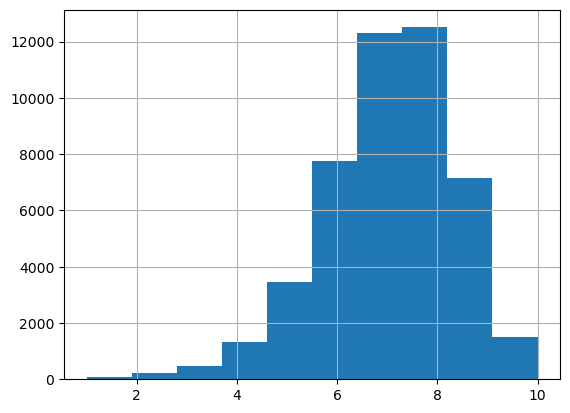

In [5]:
df_fusionné['Note_moyenne'].hist()

In [6]:
df_fusionné.groupby('Origine').mean()

/tmp/ipykernel_128/2106022310.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_fusionné.groupby('Origine').mean()


,Note_moyenne,Nombre_de_votes
Origine,,
Albania,6.800000,2005.000000
Argentina,6.725714,9917.971429
Armenia,6.033333,9292.666667
Aruba,4.100000,4807.000000
Australia,6.578049,7724.222997
...,...,...
Venezuela,7.025000,4385.500000
Vietnam,5.500000,6168.384615
West Germany,6.324390,4345.707317


In [ ]:
df_fusionné.groupby('month').mean()

In [ ]:
df_fusionné.groupby(['month','Origine']).mean()